# LLM Fine-tuning data preparation

The goal of this notebook is to prepare an instruct dataset to run a fine-tuning procedure on a Q&A use case.

### 1. Requirements


In [8]:
!pip install --upgrade pip
!pip install -q datasets transformers sentence_transformers faiss-cpu python-dotenv seaborn matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datasets import load_dataset
from transformers import AutoTokenizer

In [2]:
# load env var in secret config file
load_dotenv()

True

In [3]:
# Global configs
LLM_MODEL_ID = "meta-llama/Llama-3.1-8B" # official version
# LLM_MODEL_ID = "NousResearch/Meta-Llama-3.1-8B" # workaround

#### Helpers

In [11]:
# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


## 2. Load dataset 

In [4]:
# here we are going to use the "garage-bAInd/Open-Platypus" to prepare our instruction set 
dataset_id = "garage-bAInd/Open-Platypus"
dataset = load_dataset(dataset_id)
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [5]:
first_datapoint = dataset['train'][5]
print(f"---INSTRUCTION---\n{first_datapoint['instruction']}\n")
print(f"---OUTPUT---\n{first_datapoint['output']}")

---INSTRUCTION---
How many four-digit numbers greater than 2999 can be formed such that the product of the middle two digits exceeds 5?

---OUTPUT---
For the first digit, there are seven choices (3, 4, 5, 6, 7, 8, or 9). For the last digit, there are ten choices (0 through 9).

We know that if either of the middle digits is 0, their product will not exceed 5. So, only consider pairs of middle digits formed from choosing two numbers between 1 and 9, inclusive. There are $9 \cdot 9$ such pairs possible. The only pairs whose product will not exceed 5 are 11, 12, 13, 14, 15, 21, 22, 31, 41, and 51. Thus, there are $9 \cdot 9 - 10 = 71$ ways in which we can choose the middle two digits.

Thus, there are $ 7 \cdot 71 \cdot 10 = 4970$ such numbers.


In [6]:
# viz dataset as pandas dataframe
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


In [7]:
# It's important to viz the number of tokens per example to understand our token distribution 
tokenizer = AutoTokenizer.from_pretrained(
    LLM_MODEL_ID,
    token=os.getenv('RESEARCH_HF_TOKEN')
)

# instructions token count 
instruction_token_counts = [
    len(tokenizer.tokenize(record["instruction"])) for record in dataset["train"]
]

# outputs token count 
outputs_token_counts = [
    len(tokenizer.tokenize(record["output"])) for record in dataset["train"]
]

# combined token count 
combined_token_counts = [instruct_count + output_count  for (instruct_count, output_count) in zip(instruction_token_counts, outputs_token_counts)]


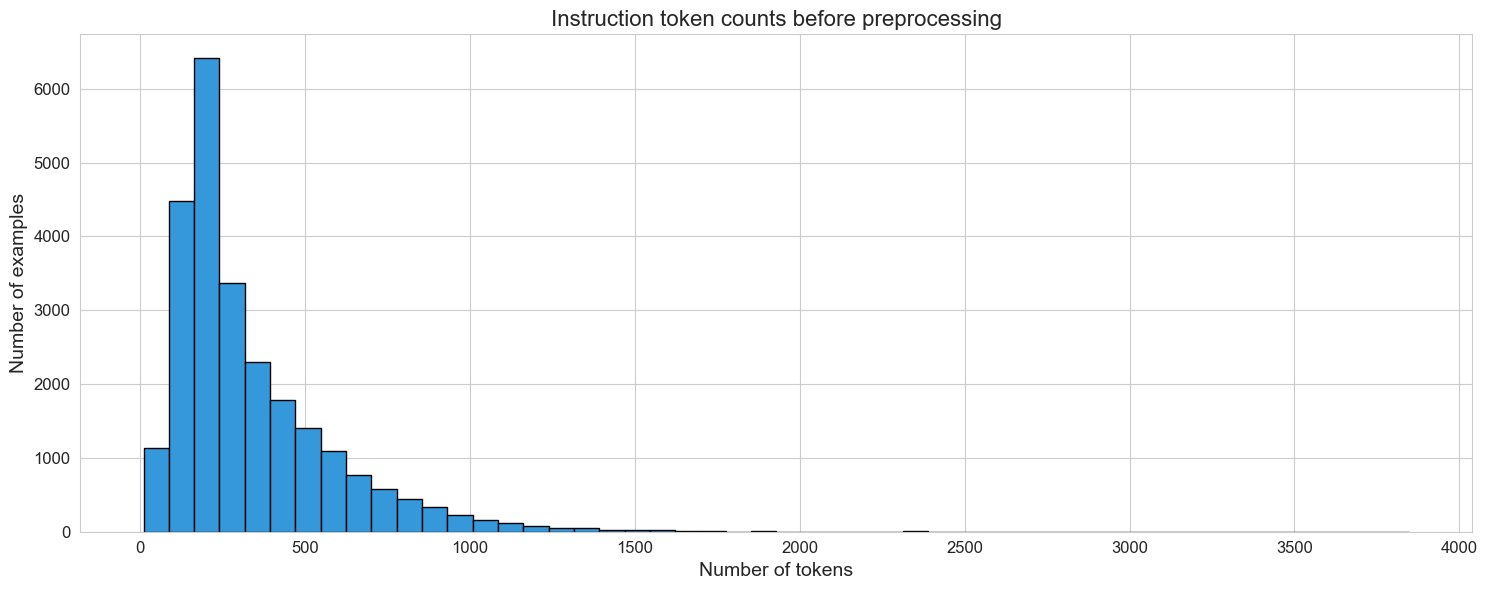

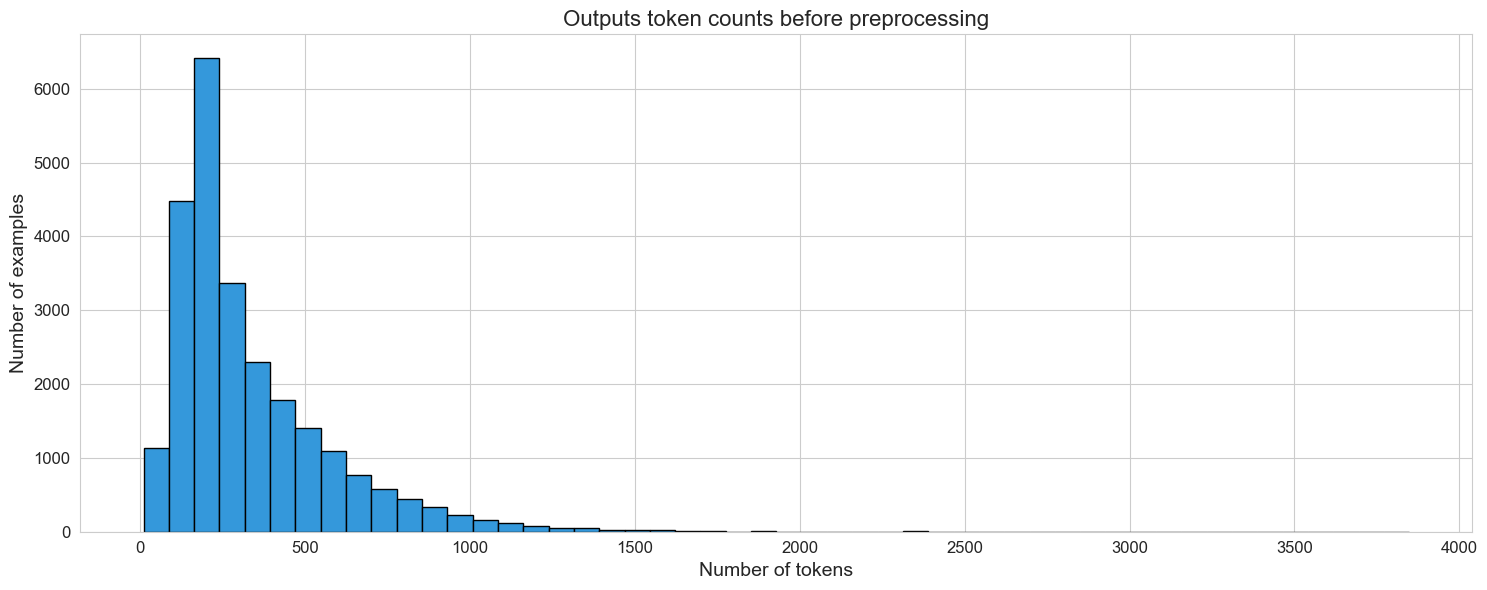

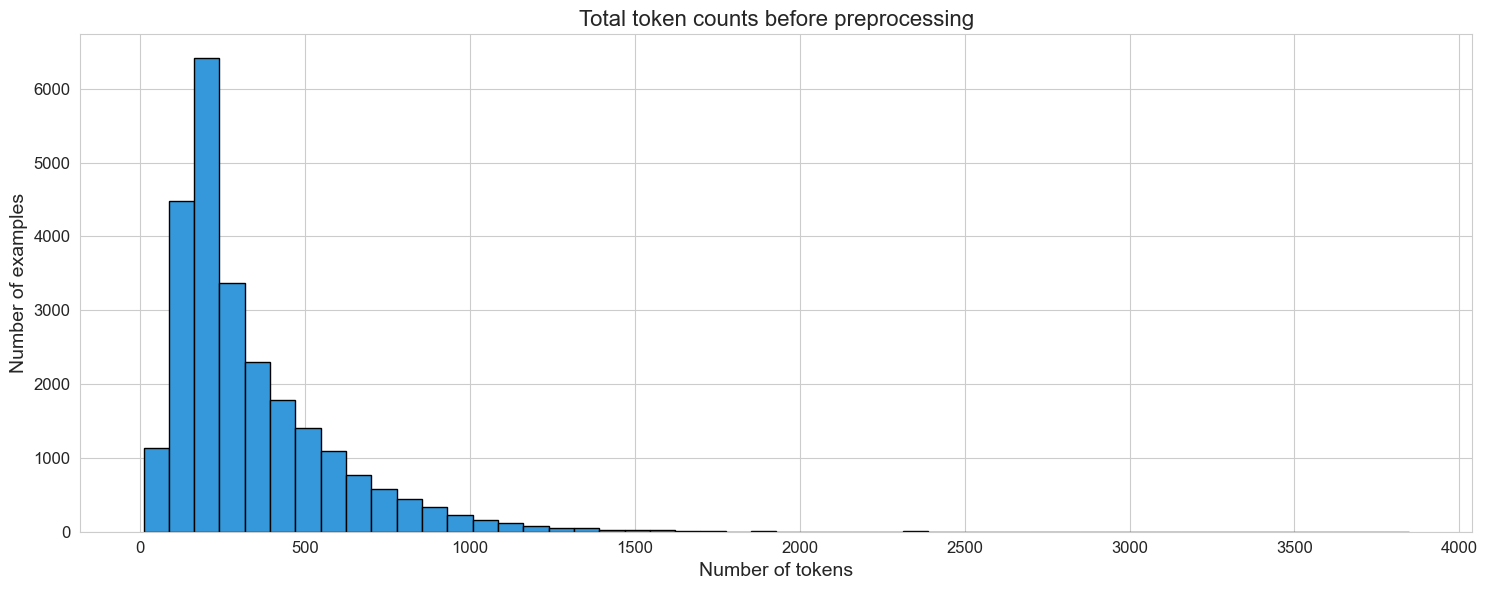

In [13]:
plot_distribution(
    token_counts=combined_token_counts,
    title="Instruction token counts before preprocessing"
)

plot_distribution(
    token_counts=combined_token_counts,
    title="Outputs token counts before preprocessing"
)

plot_distribution(
    token_counts=combined_token_counts,
    title="Total token counts before preprocessing"
)

In [32]:
# Filter rows with more than 2048 tokens
valid_indices = [i for i in range(len(combined_token_counts)) if combined_token_counts[i] <= 2048]

# filtering percentage 
removal_percent = (len(combined_token_counts) - len(valid_indices))*100 / len(combined_token_counts)
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows")
print(f"Percentage example removed: {removal_percent:.2f}%")

# new dataset 
dataset_token_filtered = dataset['train'].select(
    indices=valid_indices
)
dataset_token_filtered_token_count = [combined_token_counts[i] for i in valid_indices]

Removing 15 rows
Percentage example removed: 0.06%


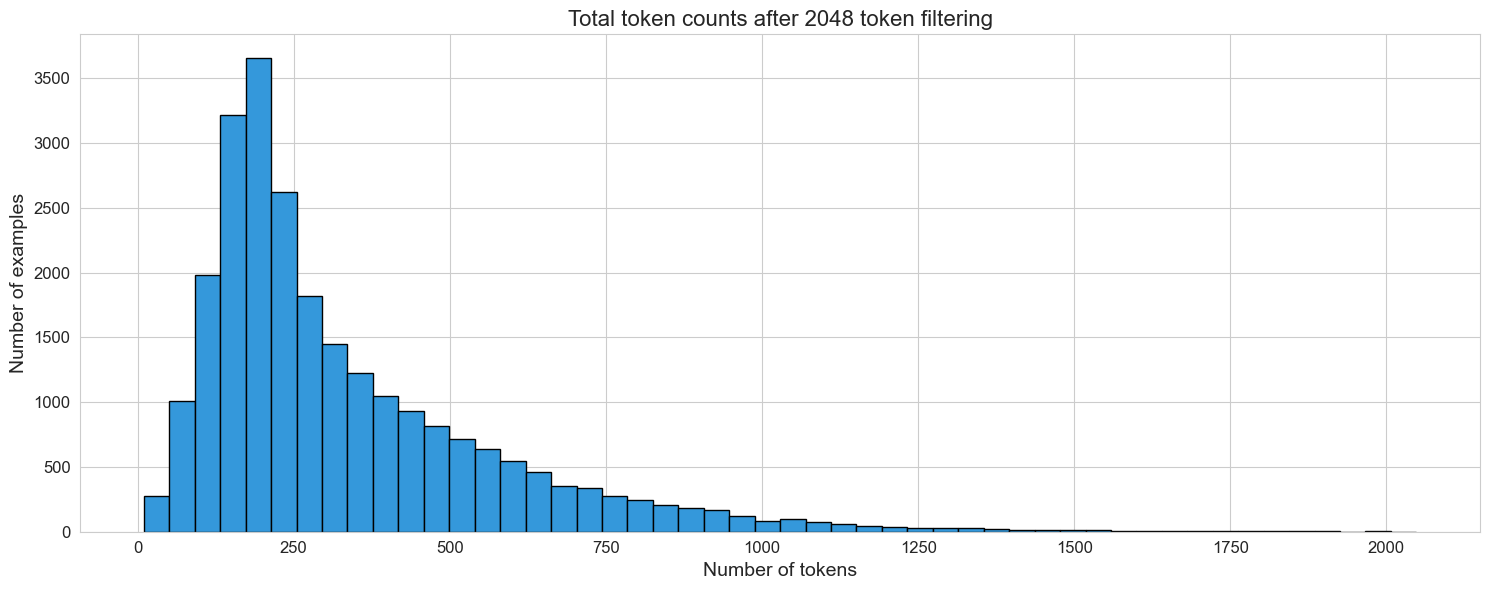

In [33]:
# display new distribution 
plot_distribution(
    token_counts=dataset_token_filtered_token_count,
    title='Total token counts after 2048 token filtering'
)